In [1]:
# Importing all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data understanding, Exploration and Cleaning

#### Reading the data

In [2]:
#Reading the dataset
houses = pd.read_csv('train.csv')
houses.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
houses.shape

(1460, 81)

In [4]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### Missing value treatment

In [5]:
findingNulls = pd.DataFrame(houses.isnull().sum().sort_values(ascending=False))
findingNulls

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
...,...
CentralAir,0
SaleCondition,0
Heating,0
TotalBsmtSF,0


In [6]:
findingNulls = findingNulls[findingNulls[0]>0]
findingNulls

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageCond,81
GarageType,81
GarageYrBlt,81
GarageFinish,81


Above are the columns that contain null values, and we need to handle these

In [7]:
findingNulls = findingNulls.reset_index()
findingNulls.rename(columns={'index':'Columns', 0:'NullValues'}, inplace=True)
#Percentage of null values in each column
findingNulls['PercentageNulls'] = (findingNulls.NullValues/len(houses))*100
findingNulls

,Columns,NullValues,PercentageNulls
0,PoolQC,1453,99.520548
1,MiscFeature,1406,96.301370
2,Alley,1369,93.767123
3,Fence,1179,80.753425
4,FireplaceQu,690,47.260274
5,LotFrontage,259,17.739726
6,GarageCond,81,5.547945
7,GarageType,81,5.547945
8,GarageYrBlt,81,5.547945
9,GarageFinish,81,5.547945


Above is the list of columns with the percentage of null values in each. We can clearly see that PoolQC, MiscFeature, Alley and Fence have more than 80% values missing in them. So they will not add much value to the model. We should drop these.

In [8]:
houses.drop(columns={'PoolQC', 'MiscFeature', 'Alley', 'Fence'}, axis=1, inplace=True)
houses.shape

(1460, 77)

##### Looking through each column left, containing null values, and seeing how to impute values

##### FireplaceQu

In [9]:
houses.FireplaceQu.value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [10]:
houses.FireplaceQu.isnull().sum()

690

In [11]:
#We can see from data dictionary that a missing value means No Fireplace. 
#Thus replacing missing values with understandable string NoFire - No Fireplace
houses.FireplaceQu.fillna('NoFire', inplace=True)

In [12]:
houses.FireplaceQu.isnull().sum()

0

##### LotFrontage

In [13]:
houses.LotFrontage.describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

<AxesSubplot:xlabel='LotFrontage', ylabel='Density'>

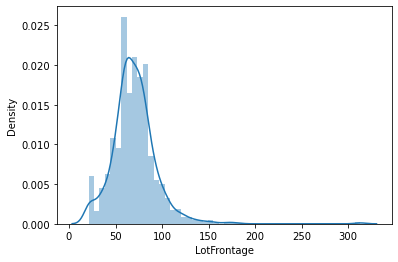

In [14]:
#Looks like there are outliers. Plotting value distributions
sns.distplot(houses.LotFrontage)

<AxesSubplot:>

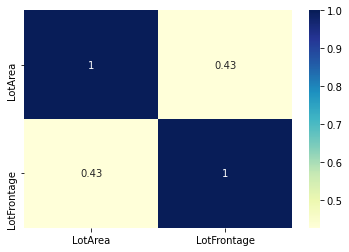

In [15]:
#Checking of there is a correlation between between LotFrontage and LotArea
#If there is, we can try calculating missing values from there
sns.heatmap(houses[{'LotFrontage','LotArea'}].corr(), annot=True, cmap='YlGnBu')

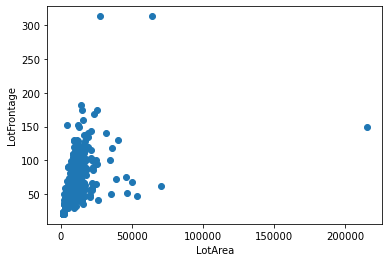

In [16]:
plt.scatter(houses['LotArea'],houses['LotFrontage'])
plt.xlabel('LotArea')
plt.ylabel('LotFrontage')
plt.show()

We can see above that the correlation between LotFrontage and LotArea is not enough that we can fetch the missing values of LotFrontage from LotArea

Since this is a continuous variable and has outliers, imputing values with median would be a good idea

In [17]:
houses.LotFrontage.isnull().sum()

259

In [18]:
houses.LotFrontage.fillna(houses.LotFrontage.median(), inplace=True)
houses.LotFrontage.isnull().sum()

0

##### Garage related columns - GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond

In [19]:
#Finding all null values in garage related columns
houses[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']].isnull().sum()

GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64

Data is consitent. We have 81 rows with all Garage columns as null. This means there is no garage for those houses, and we can replce the null values with NoGarage

In [20]:
#Replacing all null values by NoGarage
houses[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']] = \
houses[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']].apply(lambda x:x.fillna('NoGarage'))

In [21]:
#Verifying that all null values in garage related columns are filled now
houses[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']].isnull().sum()

GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

##### Basement related columns - BsmtQual, BsmtCond, BsmtExposure,BsmtFinType1,BsmtFinType2 

In [22]:
#Number of null values in each
houses[{'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2'}].isnull().sum()

BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
dtype: int64

Null values is the above columns mean that the basement does not exist. These are all categorical columns and we can replace the null values by 'NoBasement'.

Also, we can notice that two of these columns have 38 nulls, while three have 37 nulls. Ideally the numbers should be same. We will bring these in sync too because currently data looks inconsistent

In [23]:
houses.shape

(1460, 77)

In [24]:
#Finding the first inconsistent row to drop and dropping them
houses = houses[~((houses.BsmtFinType2.isnull() & houses.BsmtCond.notnull() & houses.BsmtFinType1.notnull() & houses.BsmtQual.notnull()))]
houses.shape

(1459, 77)

In [25]:
#Finding the second inconsistent row to drop and dropping them
houses = houses[~((houses.BsmtExposure.isnull() & houses.BsmtCond.notnull() & houses.BsmtFinType1.notnull() & houses.BsmtQual.notnull()))]
houses.shape

(1458, 77)

In [26]:
#Verifying if null values are consistent in all Basement columns now
houses[{'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2'}].isnull().sum()

BsmtQual        37
BsmtCond        37
BsmtExposure    37
BsmtFinType1    37
BsmtFinType2    37
dtype: int64

Null values are consistent now

In [27]:
#Replacing all null values by NoBasement
houses[['BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2']] = \
houses[{'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2'}].apply(lambda x:x.fillna('NoBasement'))

In [28]:
#Verifying that all null values are filled now
houses[{'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2'}].isnull().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
dtype: int64

In [29]:
houses[['BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2']].head(20)

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
0,Gd,TA,No,GLQ,Unf
1,Gd,TA,Gd,ALQ,Unf
2,Gd,TA,Mn,GLQ,Unf
3,TA,Gd,No,ALQ,Unf
4,Gd,TA,Av,GLQ,Unf
5,Gd,TA,No,GLQ,Unf
6,Ex,TA,Av,GLQ,Unf
7,Gd,TA,Mn,ALQ,BLQ
8,TA,TA,No,Unf,Unf
9,TA,TA,No,GLQ,Unf


##### MasVnrArea 

In [30]:
houses.MasVnrArea.describe()

count    1450.000000
mean      103.524828
std       181.117506
min         0.000000
25%         0.000000
50%         0.000000
75%       165.750000
max      1600.000000
Name: MasVnrArea, dtype: float64

<AxesSubplot:xlabel='MasVnrArea', ylabel='Density'>

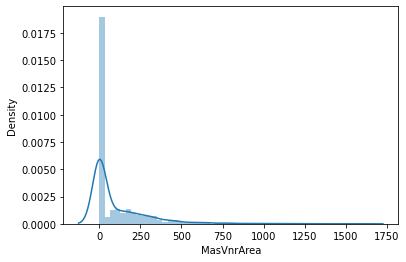

In [31]:
#Looks like there are outliers. Plotting value distributions
sns.distplot(houses.MasVnrArea)

In [32]:
houses.MasVnrArea.isnull().sum()

8

In [33]:
#Filling null values with median
houses.MasVnrArea.fillna(houses.MasVnrArea.median(), inplace=True)
houses.MasVnrArea.isnull().sum()

0

##### MasVnrType  	

In [34]:
houses.MasVnrType.unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [35]:
houses.MasVnrType.isnull().sum()

8

In [36]:
# Replacing Null with NoMason
houses.MasVnrType.fillna("NoMason", inplace=True)
houses.MasVnrType.isnull().sum()

0

##### Electrical

In [37]:
houses.Electrical.unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

In [38]:
houses.Electrical.isnull().sum()

1

In [39]:
#Just one value is missing and we can replace this with mode
houses.Electrical.mode()

0    SBrkr
dtype: object

In [40]:
houses.Electrical.fillna('SBrkr', inplace=True)
houses.Electrical.isnull().sum()

0

In [41]:
#Verifying one final time that no null value exist now
pd.DataFrame(houses.isnull().sum()).describe()

,0
count,77.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


#### Correcting Data types of categorical variables

In [42]:
#Taking a subset of all numerical columns from the houses dataset
houses_numeric = houses.select_dtypes(include=['float64', 'int64'])
houses_numeric.shape

(1458, 37)

In [43]:
#Listing all numeric columns
houses_numeric.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [44]:
#Dropping Id column from houses
houses.drop(columns='Id', axis=1, inplace=True)
houses.shape

(1458, 76)

In [45]:
#Dropping Id column from houses_numeric
houses_numeric.drop(columns='Id', axis=1, inplace=True)
houses_numeric.shape

(1458, 36)

Now checking which of these are actually categorical variables so that they can be converted to object type, if they are unordered. And then one hot encoding is performed over them

    'MSSubClass',
    'OverallQual',
    'OverallCond',
    'YearBuilt',
    'YearRemodAdd',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageYrBlt',
    'GarageCars',
    'MiscVal'
    'MoSold',
    'YrSold',



In [46]:
houses.MSSubClass.unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40])

MSSubClass represents type of dwelling/Unordered/Dummies must be created

In [47]:
houses['MSSubClass']=houses.MSSubClass.astype('object')

OverallQual and OverallCond have a sense of order and thus dummies are not needed

There are three Year related columns - YearBuilt, YearRemodAdd, YrSold. We can calculate Age at which house was sold by subtracting YearBuilt from YrSold, and store this as AgeOfHouse. We can also calculate age of house since the remodelling was done

In [48]:
#Creating derived column for Age of house
houses['AgeOfHouse'] = houses.YrSold - houses.YearBuilt

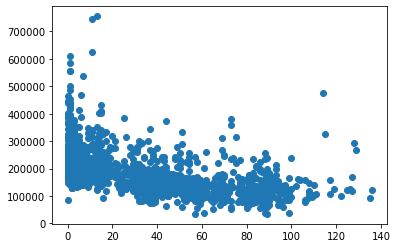

In [49]:
#Checking linear relation between age and price
plt.scatter(x=houses.AgeOfHouse, y=houses.SalePrice)
plt.show()

In [50]:
#Creating derived columns for AgeSinceRemodelled for the time passed from the time of remodelling
houses['AgeSinceRemodelled'] = houses.YrSold - houses.YearRemodAdd

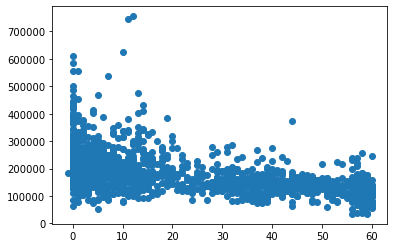

In [51]:
#Checking linear relation between age since remodelling and price
plt.scatter(x=houses.AgeSinceRemodelled, y=houses.SalePrice)
plt.show()

In [52]:
#Dropping YrSold, YearBuilt, YearRemodAdd
houses.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd'], axis=1, inplace=True)
houses.shape

(1458, 75)

In [53]:
houses.BsmtFullBath.unique()

array([1, 0, 2, 3])

Ordered | Dummies not needed

In [54]:
houses.BsmtHalfBath.unique()

array([0, 1, 2])

Ordered | Dummies not needed

In [55]:
houses.FullBath.unique()

array([2, 1, 3, 0])

Ordered | Dummies not needed

In [56]:
houses.HalfBath.unique()

array([1, 0, 2])

Ordered | Dummies not needed

In [57]:
houses.BedroomAbvGr.unique()

array([3, 4, 1, 2, 0, 5, 6, 8])

Ordered | Dummies not needed

In [58]:
houses.KitchenAbvGr.unique()

array([1, 2, 3, 0])

Ordered | Dummies not needed

In [59]:
houses.TotRmsAbvGrd.unique()

array([ 8,  6,  7,  9,  5, 11,  4, 10, 12,  3,  2, 14])

Ordered | Dummies not needed

In [60]:
houses.Fireplaces.unique()

array([0, 1, 2, 3])

Ordered | Dummies not needed

In [61]:
houses.GarageCars.unique()

array([2, 3, 1, 0, 4])

Ordered | Dummies not needed

In [62]:
houses.MiscVal.unique()

array([    0,   700,   350,   500,   400,   480,   450, 15500,  1200,
         800,  2000,   600,  3500,  1300,    54,   620,   560,  1400,
        8300,  1150,  2500])

<AxesSubplot:xlabel='MiscVal', ylabel='SalePrice'>

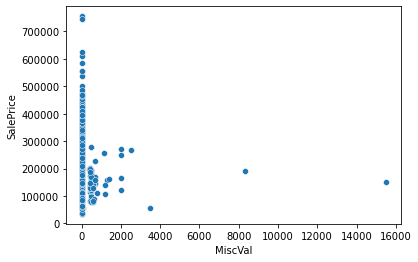

In [63]:
sns.scatterplot(houses.MiscVal, houses.SalePrice)

In [64]:
#MiscVal won't add much value. Dropping it
houses.drop(columns='MiscVal', axis=1, inplace=True)

#### Outliers of numeric variables

In [65]:
num_vars = list(houses.select_dtypes(include=['float64', 'int64']).columns)

In [66]:
num_vars

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MoSold',
 'SalePrice',
 'AgeOfHouse',
 'AgeSinceRemodelled']

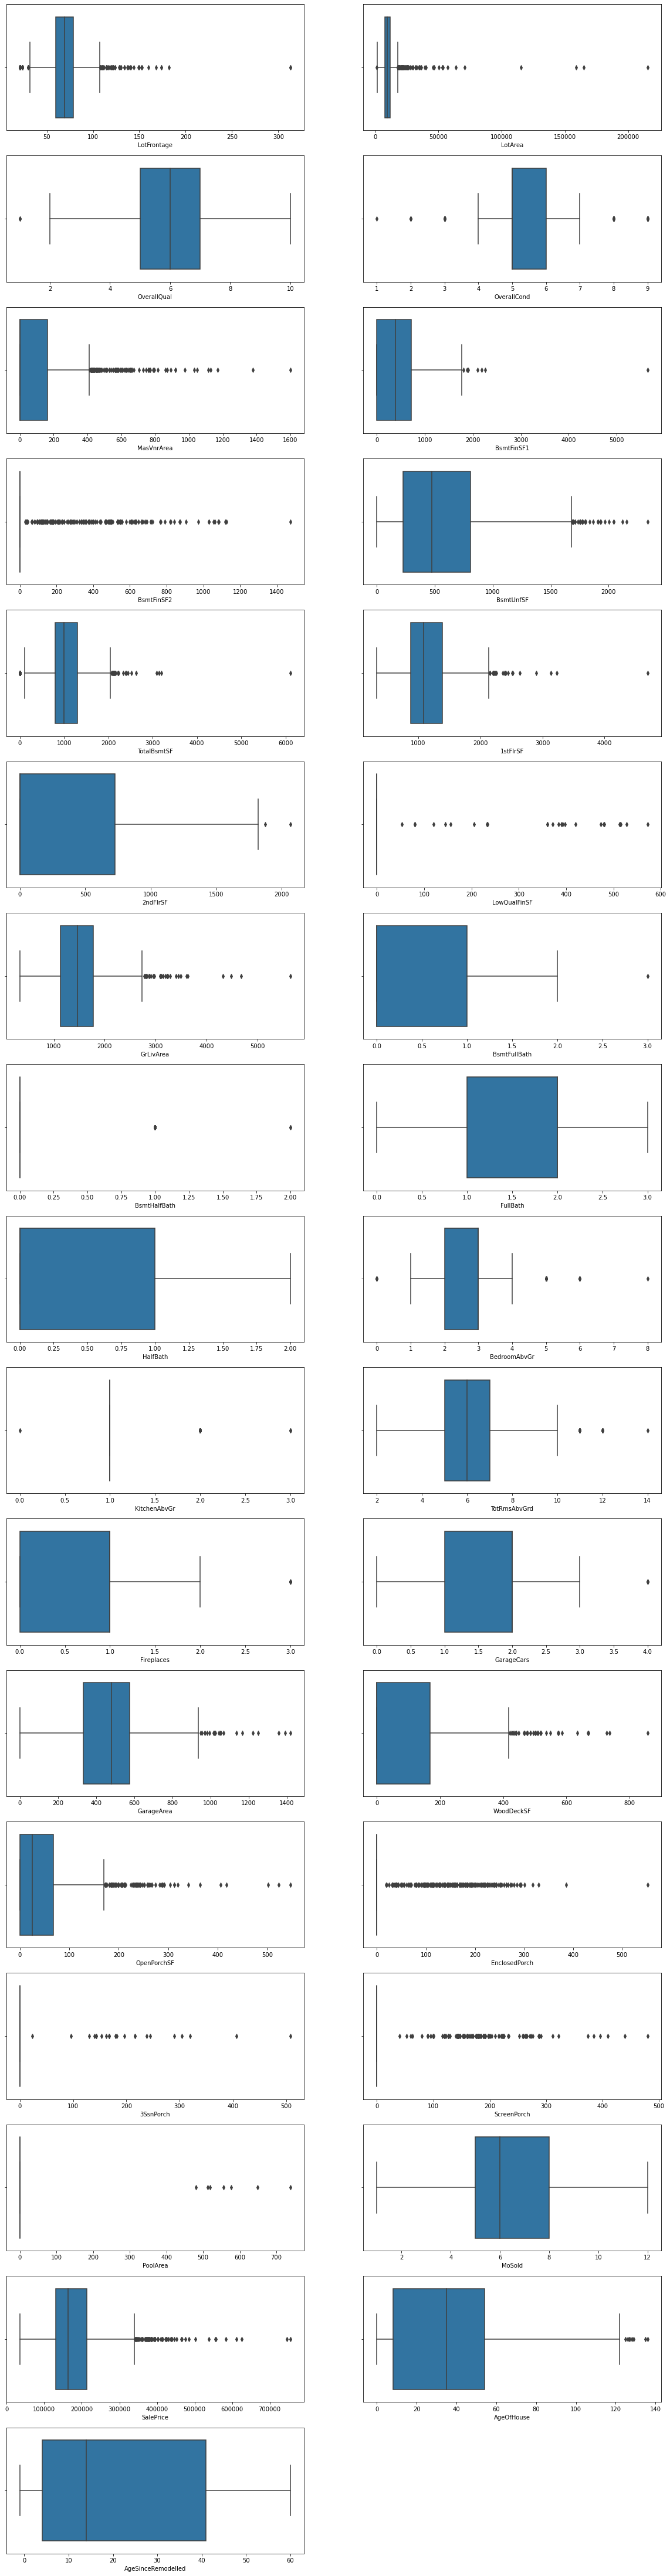

In [67]:
count = 0
plt.figure(figsize=(20,80))
for col in num_vars:
    count = count + 1
    plt.subplot(17,2,count)
    sns.boxplot(houses[col])
    plt.xlabel(col)
plt.show()

In [68]:
houses[num_vars].shape

(1458, 33)

In [69]:
# Retaining column values with SD between -3 and 3. Dropping the others as they are outliers
# Taking z score 
from scipy import stats
z = np.abs(stats.zscore(houses[num_vars]))
#Removing outliers
selected = houses[num_vars][(z < 3).all(axis=1)]
houses = houses.loc[selected.index]
houses.shape

(1026, 74)

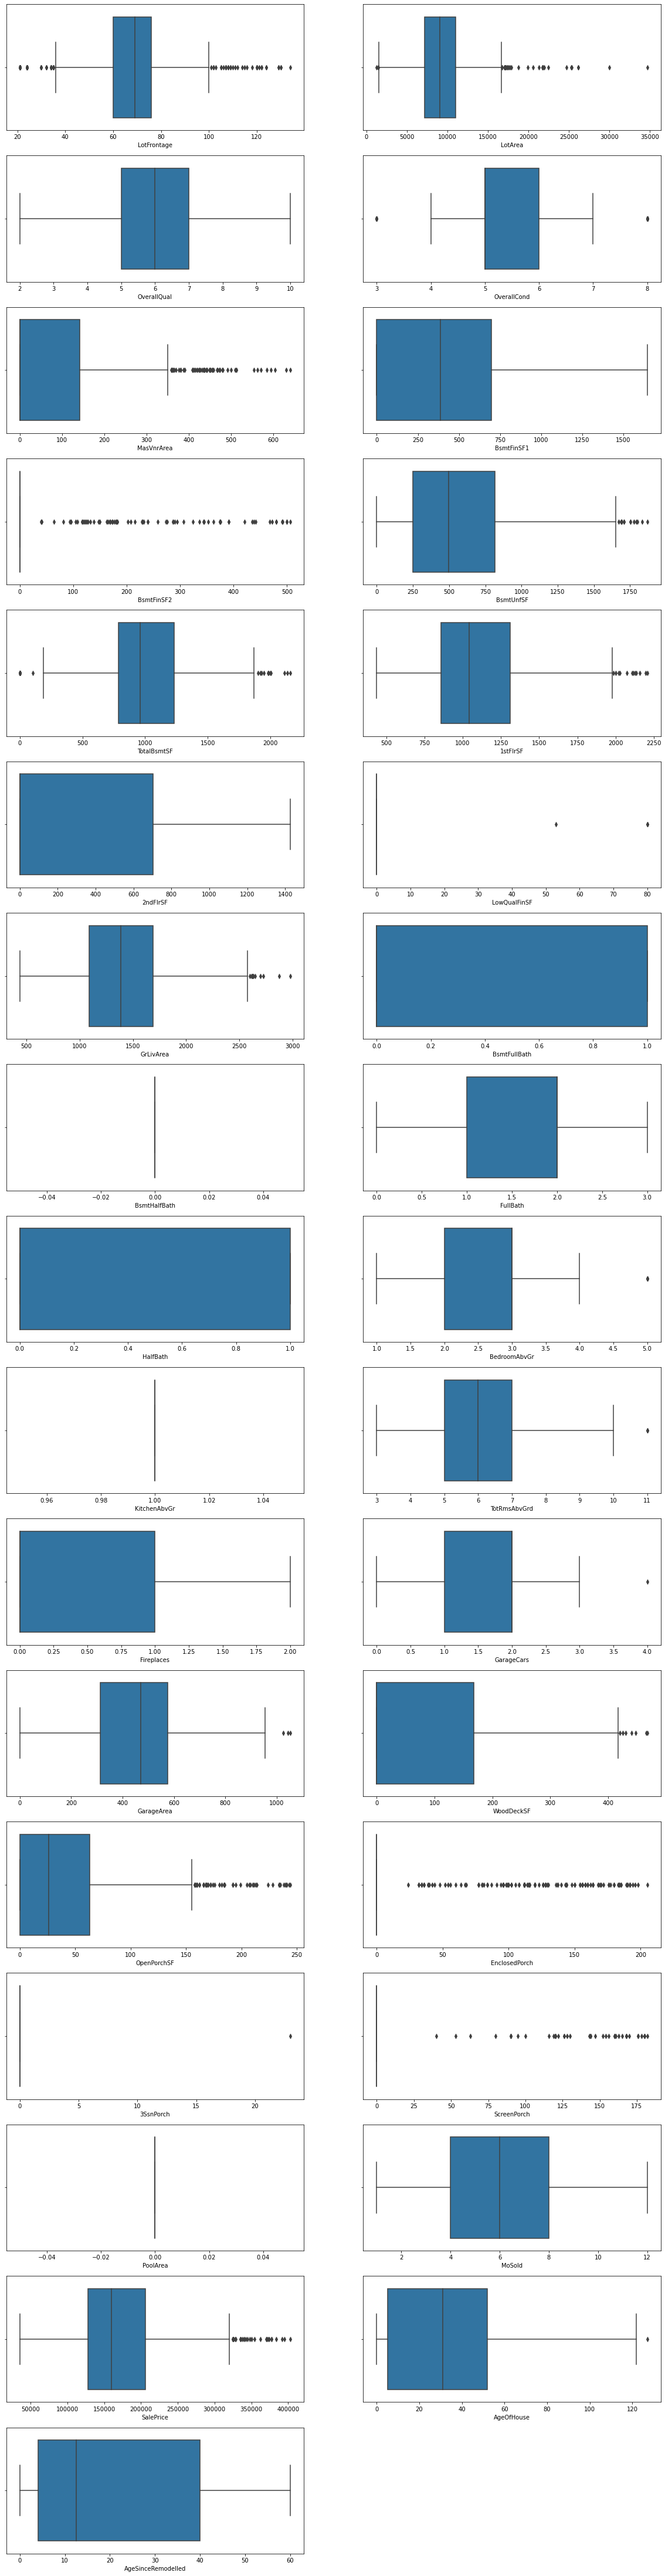

In [70]:
#Plotting boxplots to check if the some outliers are removed now
count = 0
plt.figure(figsize=(20,80))
for col in num_vars:
    count = count + 1
    plt.subplot(17,2,count)
    sns.boxplot(houses[col])
    plt.xlabel(col)
plt.show()

##### Taking the information from boxplots to filter out the columns that contain only one value for all columns, and then dropping them as they would not add value to the model

In [71]:
houses['BsmtHalfBath'].value_counts()

0    1026
Name: BsmtHalfBath, dtype: int64

In [72]:
houses.LowQualFinSF.value_counts()

0     1022
80       3
53       1
Name: LowQualFinSF, dtype: int64

In [73]:
houses.KitchenAbvGr.value_counts()

1    1026
Name: KitchenAbvGr, dtype: int64

In [74]:
houses.PoolArea.value_counts()

0    1026
Name: PoolArea, dtype: int64

In [75]:
#Dropping columns with single values
houses.drop(columns=['BsmtHalfBath', 'KitchenAbvGr', 'PoolArea'], axis=1, inplace=True)
houses.shape

(1026, 71)

In [76]:
#Revising our num_vars variable
num_vars = list(houses.select_dtypes(include=['float64', 'int64']).columns)

#### Checking Categorical variables of object type

In [77]:
houses_objectType = houses.select_dtypes(include=['object'])
houses_objectType.shape

(1026, 41)

In [78]:
houses_objectType.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [79]:
#Dropping categorical columns with single values
cat_vars = list(houses.select_dtypes(include=['object']).columns)

unique = houses[cat_vars].apply(lambda x:x.nunique())
houses = houses.drop(unique[unique<2].index, axis=1)
houses.select_dtypes(include=['object']).shape

(1026, 40)

#### Checking value distribution of target variable

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

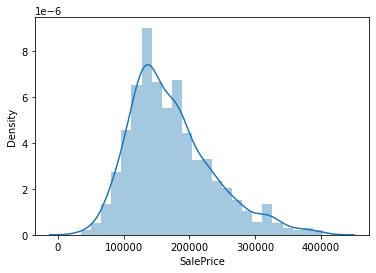

In [80]:
sns.distplot(houses.SalePrice)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

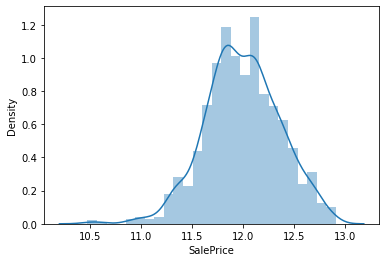

In [81]:
#Target variable distribution is skewed. 
#We can try doing a log transformation to get a normal distribution
sns.distplot(np.log(houses.SalePrice))

In [82]:
#Since we get a better distribution by taking a log, we can replace 
#the value of target variable by log values
houses['SalePrice'] = np.log(houses.SalePrice)

##### One final check for all columns with too many same values and dropping them, since we have too many columns and it will increase complexity

In [83]:
all_cols = houses.columns

In [84]:
target_cols = {}
for col in all_cols:
    if max(list(houses[col].value_counts(normalize=True).sort_values(ascending=False).head(1)))>=0.85:
        target_cols[col] = max(list(houses[col].value_counts(normalize=True).sort_values(ascending=False).head(1)))
target_cols

{'Street': 0.9980506822612085,
 'LandContour': 0.9200779727095516,
 'LandSlope': 0.9629629629629629,
 'Condition1': 0.8859649122807017,
 'Condition2': 0.9961013645224172,
 'BldgType': 0.8576998050682261,
 'RoofMatl': 0.9961013645224172,
 'ExterCond': 0.8976608187134503,
 'BsmtCond': 0.9142300194931774,
 'BsmtFinType2': 0.9074074074074074,
 'BsmtFinSF2': 0.9259259259259259,
 'Heating': 0.9844054580896686,
 'CentralAir': 0.9512670565302144,
 'Electrical': 0.9230019493177388,
 'LowQualFinSF': 0.9961013645224172,
 'Functional': 0.9415204678362573,
 'GarageQual': 0.9103313840155945,
 'GarageCond': 0.9200779727095516,
 'PavedDrive': 0.928849902534113,
 'EnclosedPorch': 0.878167641325536,
 '3SsnPorch': 0.9990253411306043,
 'ScreenPorch': 0.9551656920077972,
 'SaleType': 0.8703703703703703}

In [85]:
pd.DataFrame({'Columns':list(target_cols.keys()), 'PerSameVals':\
             list(target_cols.values())})

,Columns,PerSameVals
0,Street,0.998051
1,LandContour,0.920078
2,LandSlope,0.962963
3,Condition1,0.885965
4,Condition2,0.996101
5,BldgType,0.857700
6,RoofMatl,0.996101
7,ExterCond,0.897661
8,BsmtCond,0.914230
9,BsmtFinType2,0.907407


In [86]:
houses.drop(list(target_cols.keys()), axis=1, inplace=True)
houses.shape

(1026, 47)

## 2. Data Visualization

In [87]:
#Revising our num_vars and cat_vars variable
num_vars = list(houses.select_dtypes(include=['float64', 'int64']).columns)
cat_vars = list(houses.select_dtypes(include=['object']).columns)

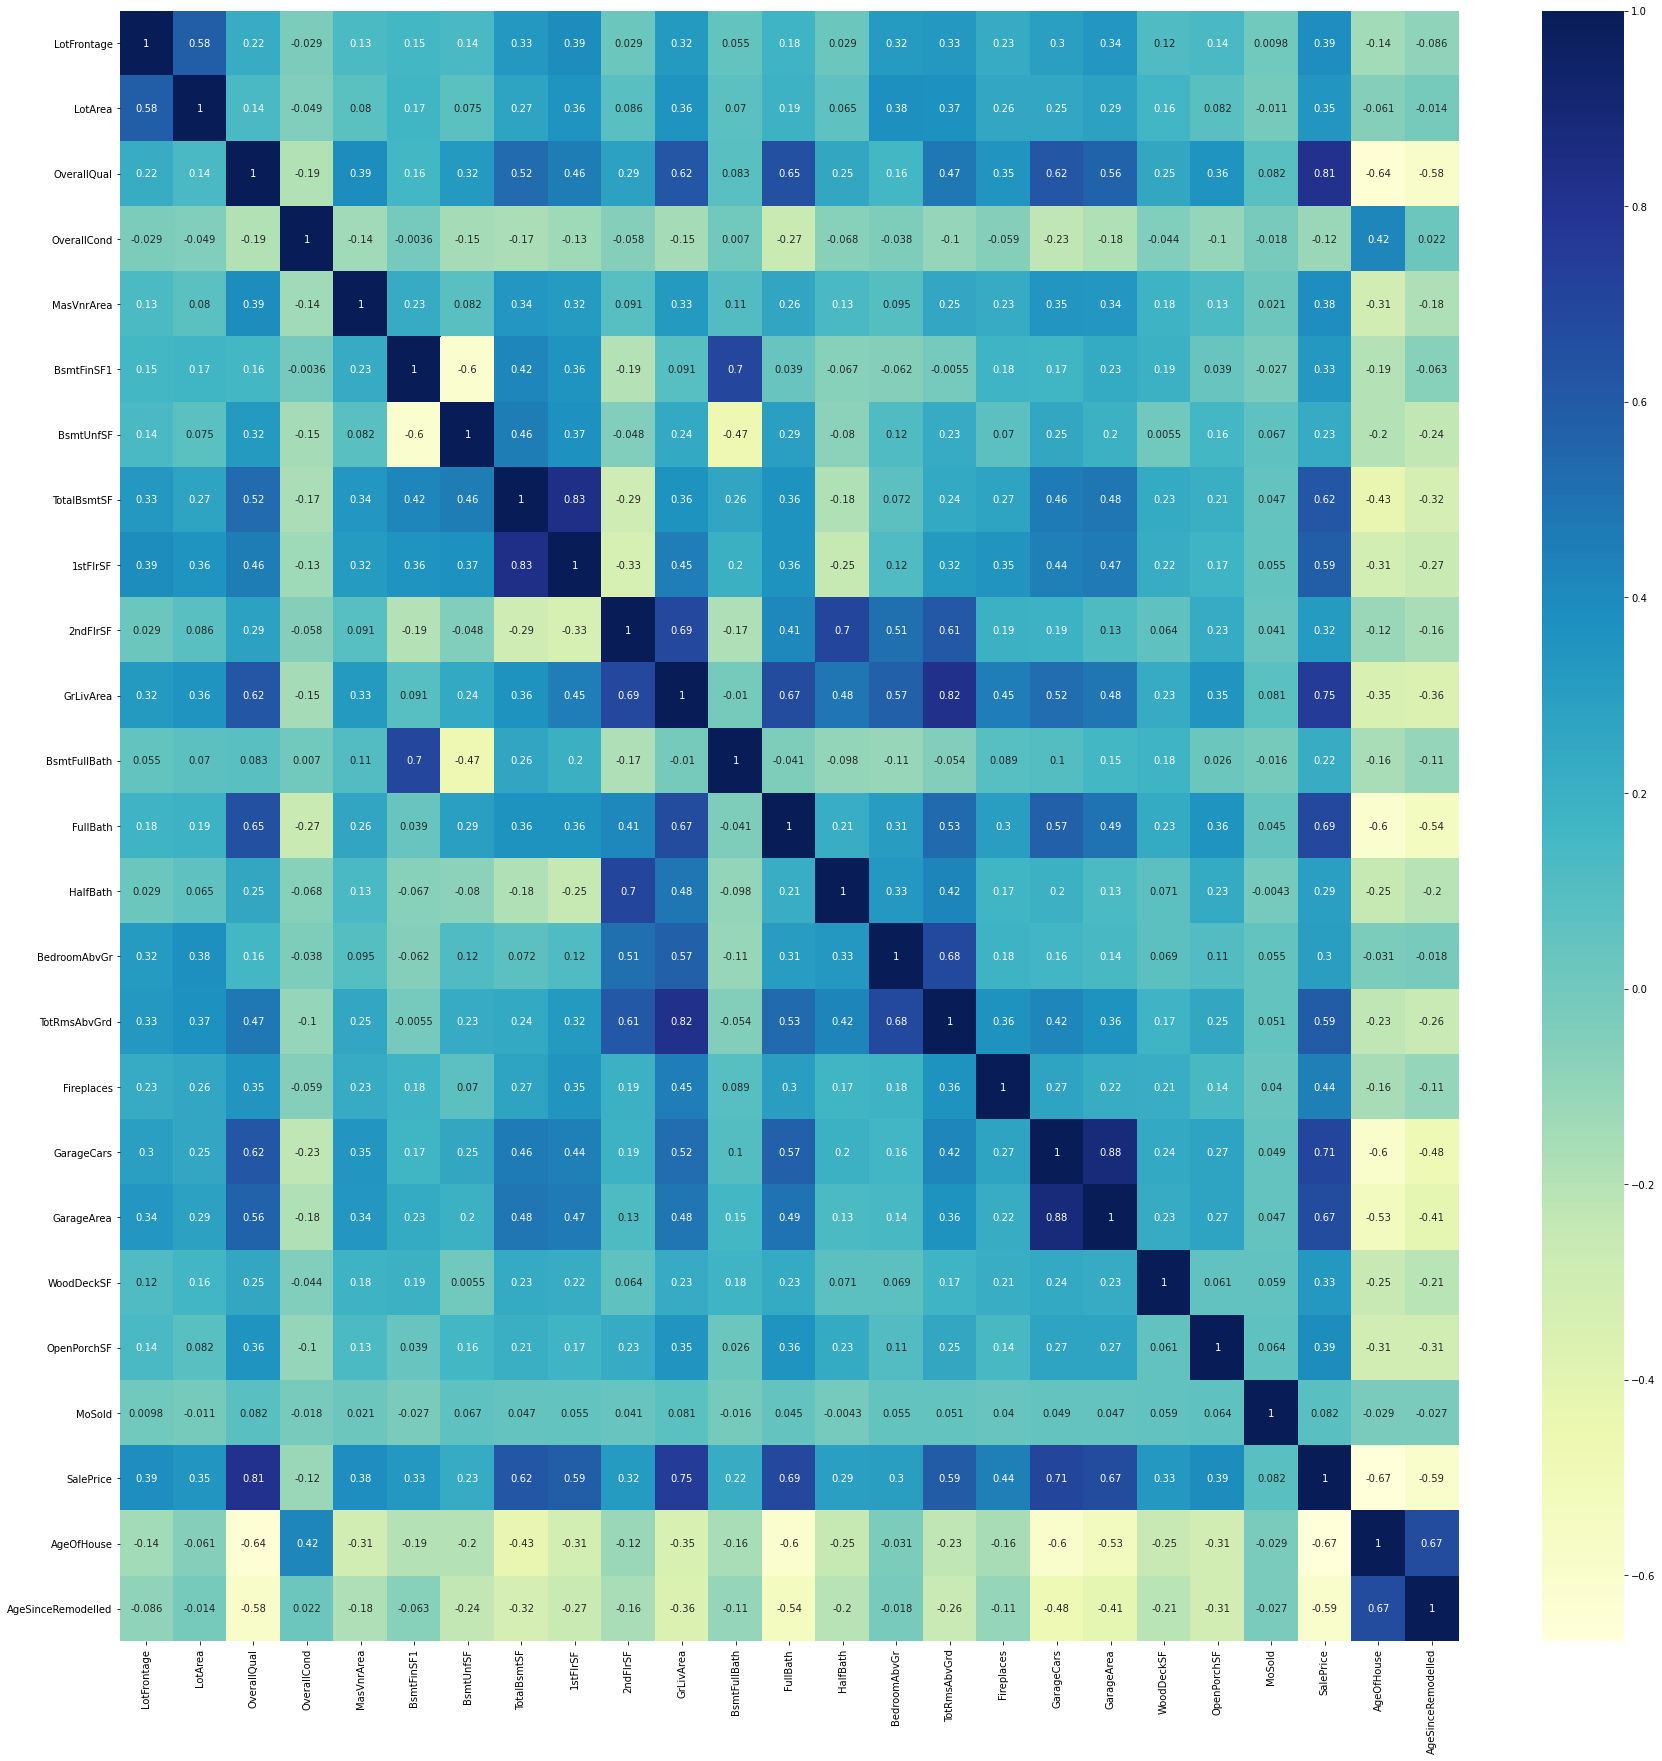

In [88]:
#Building correlation matrix
plt.figure(figsize=(30,30))
sns.heatmap(houses[num_vars].corr(), cmap="YlGnBu", annot=True)
plt.show()

High correlation columns:
- TotalBsmtSF and 1stFlrSF
- TotRmsAbvGrd & GrLivArea
- GarageCars & GarageArea

In [89]:
#Dropping TotalBsmtSF, TotRmsAbvGrd, GarageCars
houses.drop(columns=['TotalBsmtSF', 'TotRmsAbvGrd', 'GarageCars'], axis=1, inplace=True)
houses.shape

(1026, 44)

In [90]:
num_vars = list(houses.select_dtypes(include=['float64', 'int64']).columns)

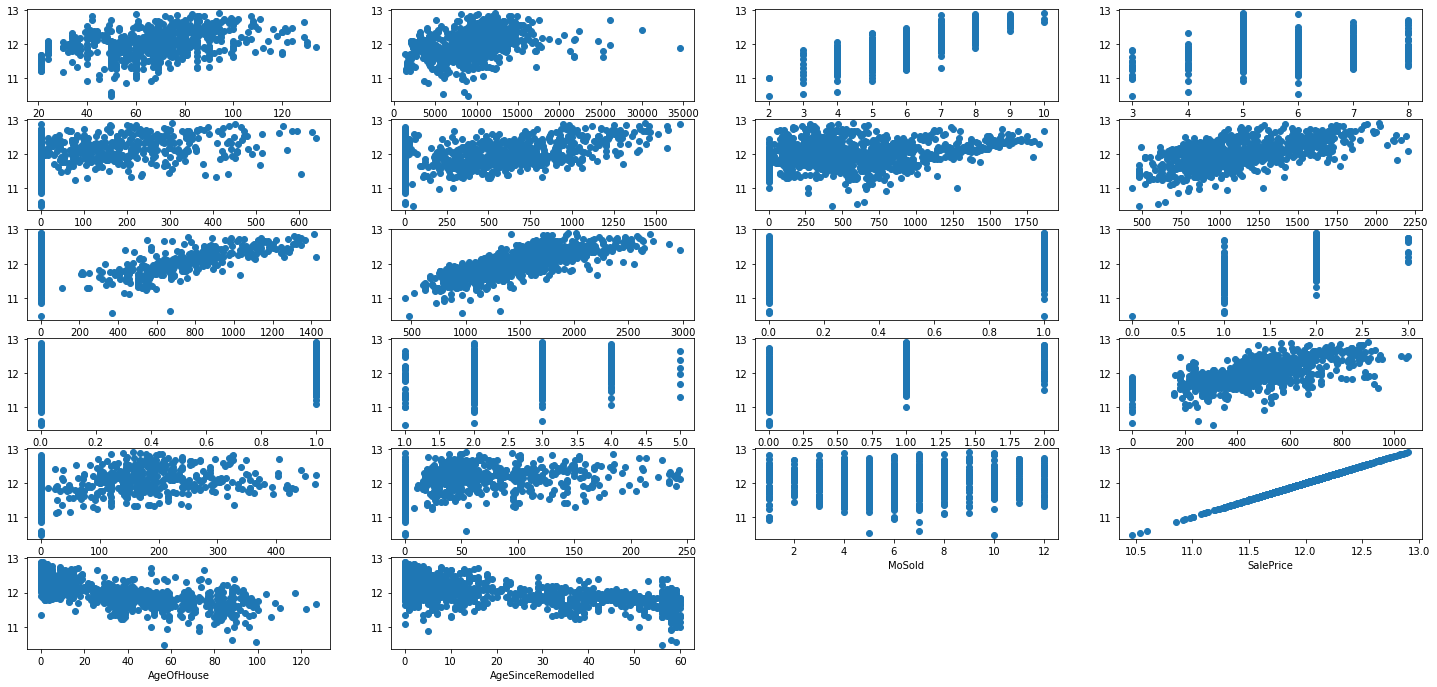

In [91]:
#Plotting correlation of numeric variables with target variable
plt.figure(figsize=(25,40))
count = 0
for col in num_vars:
    count = count + 1
    plt.subplot(20,4,count)
    plt.scatter(x=houses[col], y=houses.SalePrice)
    plt.xlabel(col)
plt.show()

Several numeric variables are showing some kind of linear relationship

## 3. Data Preparation

In [92]:
cat_vars = list(houses.select_dtypes(include=['object']).columns)
cat_vars

['MSSubClass',
 'MSZoning',
 'LotShape',
 'LotConfig',
 'Neighborhood',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'SaleCondition']

In [93]:
houses.GarageYrBlt.value_counts()

2005.0      59
2004.0      49
NoGarage    47
2006.0      46
2007.0      42
            ..
1910.0       1
1915.0       1
1952.0       1
1923.0       1
1918.0       1
Name: GarageYrBlt, Length: 94, dtype: int64

In [94]:
#Dropping since it contains NoGarage values along with the year data. To utilize this we will have to drop the 
# NoGarage rows. We will lose data and in return we wont get much value addition as we are already calculating age
# of house and age from remodeeling
houses.drop(columns='GarageYrBlt', axis=1, inplace=True)

In [95]:
#Creating dummies
cat_vars = list(houses.select_dtypes(include=['object']).columns)
houses_dummies = pd.get_dummies(houses[cat_vars], drop_first=True)
houses_dummies.head()

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
10,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [96]:
# Deleting existing categorical columns from original dataset and then concatenating
# dummies
houses.drop(columns=cat_vars, axis=1, inplace=True)
houses.shape

(1026, 22)

In [97]:
#Concatenating created dummy variables to houses
houses = pd.concat([houses, houses_dummies], axis=1)

In [98]:
houses.shape

(1026, 157)

In [99]:
list(houses.select_dtypes(include=['object']).columns)

[]

In [100]:
#Split data into X and y
y = houses.pop('SalePrice')

X = houses

In [101]:
# scaling the features - necessary before using Ridge or Lasso
from sklearn.preprocessing import scale

# storing column names in cols, since column names are lost
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       ...
       'GarageType_Detchd', 'GarageType_NoGarage', 'GarageFinish_NoGarage',
       'GarageFinish_RFn', 'GarageFinish_Unf', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=156)

In [102]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## 4. Model Building

#### Linear Regression

In [103]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [104]:
from sklearn.metrics import r2_score, mean_squared_error

In [105]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9495823663011874
-5.222469622760133e+21
4.950356809568437
2.0747176918212677e+23
0.00689464736708696
6.736096402017103e+20


We can see that simple linear regression has failed. A negative R square on test set means that it is worst than a simple mean. If we want to get a proper model through simple linear regression we will have to use RFE or manual VIF method to eliminate some features. We need not do that because we are anyway going to use better models ahead which would produce regularized model.

Moving ahead with Ridge and Lasso.

#### Ridge Regression

In [106]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    3.3s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [107]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 50}


In [108]:
#Choosing Param values closer to what we got last and fitting again

#params = {'alpha': [20, 50, 100, 150, 200, 250,300,350,400]}
#params = {'alpha': [250, 300, 350, 400, 450, 500, 550, 600, 650,
#                   700, 750, 800, 850, 900, 950, 1000]}
params = {'alpha': [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    2.2s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70,
                                   75, 80, 85, 90, 95, 100]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [109]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 55}


In [110]:
#Fitting Ridge model for alpha = 55 
alpha = 55
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)

Ridge(alpha=55)

In [111]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9423030659927991
0.8980493357855777
5.665089556959804
4.050169019974142
0.007890096875988585
0.01314989941550046


In [112]:
#Building dictonary of Ridge coefficients
ridge_coef = dict(zip(X_train.columns, ridge.coef_))
ridge_coeff_final = {}
for coef in ridge_coef:
    if ridge_coef[coef] != 0:
        ridge_coeff_final[coef] = ridge_coef[coef]

#Sorting the ridge coefficients dictionary
ridge_coeff_final_sor = \
dict(sorted(ridge_coeff_final.items(),key= lambda x:x[1], reverse=True))

In [113]:
ridge_coeff_final_sor

{'OverallQual': 0.055713104454747996,
 'GrLivArea': 0.054408678837510986,
 'OverallCond': 0.04016765883225994,
 '1stFlrSF': 0.03975291063312201,
 'BsmtFinSF1': 0.03818810382453947,
 'GarageArea': 0.03227557874086955,
 'Neighborhood_Crawfor': 0.027756464161308052,
 '2ndFlrSF': 0.025470468104456908,
 'Foundation_PConc': 0.024300605913366406,
 'BsmtUnfSF': 0.023262655825235946,
 'SaleCondition_Partial': 0.018326520991342247,
 'MSZoning_RM': 0.017044813222173702,
 'LotArea': 0.016772602901726764,
 'SaleCondition_Normal': 0.01656122846899166,
 'FullBath': 0.015961110801714418,
 'MSZoning_RL': 0.013958471012755257,
 'HalfBath': 0.01275126353160141,
 'WoodDeckSF': 0.012191813952504722,
 'MSZoning_FV': 0.011198683863860368,
 'BsmtExposure_Gd': 0.011022450858585305,
 'Neighborhood_StoneBr': 0.01084757178185862,
 'Neighborhood_Somerst': 0.010402820399322128,
 'SaleCondition_AdjLand': 0.010314302861279387,
 'BsmtFullBath': 0.01015500920297563,
 'Fireplaces': 0.01015097676206819,
 'Neighborhood_Nr

#### Lasso Regression

In [114]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)             

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    2.2s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70,
                                   75, 80, 85, 90, 95, 100]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [115]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 20}


In [116]:
params = {'alpha': [1,5,15,20,25,30,35,40]}

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.7s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1, 5, 15, 20, 25, 30, 35, 40]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [117]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 1}


In [118]:
params = {'alpha': [0.001,0.01,0.1,1,1.1,1.2,1.5]}

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.4s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 1.1, 1.2, 1.5]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [119]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.001}


In [120]:
params = {'alpha': [0.00001,0.0001,0.001,0.01]}

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.0s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [121]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.001}


In [122]:
alpha = 0.001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.001)

In [123]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9434461134911117
0.8951435884172663
5.552857138422772
4.165604932645139
0.0077337843153520505
0.013524691339756945


In [124]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.495824e-01,0.942303,0.943446
1,R2 Score (Test),-5.222470e+21,0.898049,0.895144
2,RSS (Train),4.950357e+00,5.665090,5.552857
3,RSS (Test),2.074718e+23,4.050169,4.165605
4,MSE (Train),8.303401e-02,0.088826,0.087942
5,MSE (Test),2.595399e+10,0.114673,0.116296


In [125]:
lasso_coef = dict(zip(X_train.columns, lasso.coef_))
lasso_coeff_final = {}
for coef in lasso_coef:
    if lasso_coef[coef] != 0:
        lasso_coeff_final[coef] = lasso_coef[coef]

In [126]:
#Sorting the lasso coefficients dictionary
lasso_coeff_final_sor = \
dict(sorted(lasso_coeff_final.items(),key= lambda x:x[1], reverse=True))

In [127]:
lasso_coeff_final_sor

{'GrLivArea': 0.12098103223354255,
 'OverallQual': 0.06291845005940964,
 'BsmtFinSF1': 0.05619411650347113,
 'OverallCond': 0.049201353663433804,
 'BsmtUnfSF': 0.034798541061415424,
 'Neighborhood_Crawfor': 0.03331751453310929,
 'GarageArea': 0.03223860621272623,
 'Foundation_PConc': 0.020870927076598957,
 'SaleCondition_Partial': 0.020384693199760443,
 'SaleCondition_Normal': 0.01909679876112682,
 'LotArea': 0.017623169311342012,
 'SaleCondition_AdjLand': 0.012588839890098945,
 'WoodDeckSF': 0.010679043993678687,
 'BsmtFullBath': 0.010216323137742308,
 'MSZoning_FV': 0.009231205320754278,
 'MSZoning_RM': 0.009129714802967221,
 'BsmtExposure_Gd': 0.00912800934988578,
 'Neighborhood_StoneBr': 0.009002693767362232,
 'HouseStyle_1Story': 0.008734933441570641,
 'MSZoning_RL': 0.008724544406865273,
 'Neighborhood_Somerst': 0.008475369970887325,
 'Fireplaces': 0.00814318692850104,
 'Neighborhood_BrkSide': 0.008125969531514196,
 'LotConfig_CulDSac': 0.008084161062957224,
 'Neighborhood_NridgH

#### Changes in coefficients after regularization

In [128]:
betas = pd.DataFrame(index=X.columns)
betas.rows = X.columns

In [129]:
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [130]:
pd.set_option('display.max_rows', None)
betas

,Linear,Ridge,Lasso
LotFrontage,6.191844e-04,6.508582e-03,0.006071
LotArea,2.248865e-02,1.677260e-02,0.017623
OverallQual,5.561939e-02,5.571310e-02,0.062918
OverallCond,4.636625e-02,4.016766e-02,0.049201
MasVnrArea,7.401255e-03,7.968830e-03,0.004612
BsmtFinSF1,6.450717e-02,3.818810e-02,0.056194
BsmtUnfSF,4.824308e-02,2.326266e-02,0.034799
1stFlrSF,3.871985e-01,3.975291e-02,0.000000
2ndFlrSF,5.026539e-01,2.547047e-02,0.000000
GrLivArea,-4.058241e-01,5.440868e-02,0.120981


#### Residual Analysis

TRAIN DATA

Text(0.5, 0, 'Errors')

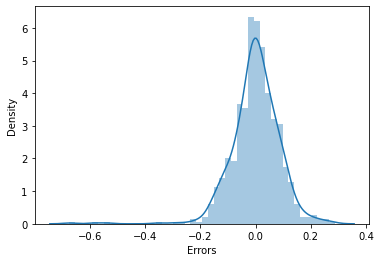

In [131]:
sns.distplot(y_train-y_pred_train)
plt.xlabel('Errors')

TEST DATA

Text(0.5, 0, 'Errors')

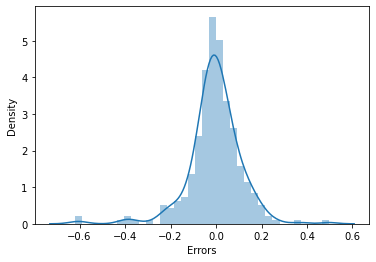

In [132]:
sns.distplot(y_test-y_pred_test)
plt.xlabel('Errors')

Error distribution is normal. Which was required

Residual vs Predicted

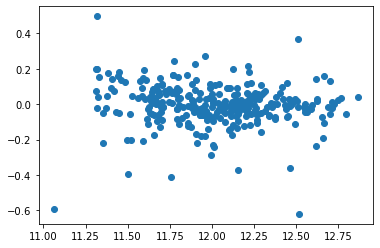

In [133]:
plt.scatter(x= y_pred_test, y= y_test-y_pred_test)

We can see above that the spread is constant and there is no pattern

#### Additional code for subjective questions

#### ----------------------------------------------------------

##### Lasso regression with double the value of Alpha

In [134]:
alpha = 0.002

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.002)

In [135]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric_2lasso = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric_2lasso.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric_2lasso.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric_2lasso.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric_2lasso.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric_2lasso.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric_2lasso.append(mse_test_lr**0.5)

0.9395614061722118
0.8949597427484749
5.934284942912323
4.17290852441605
0.008265020811855603
0.01354840430005211


In [136]:
lasso_coef = dict(zip(X_train.columns, lasso.coef_))
lasso_coeff_final = {}
for coef in lasso_coef:
    if lasso_coef[coef] != 0:
        lasso_coeff_final[coef] = lasso_coef[coef]

#Sorting the lasso coefficients dictionary
lasso_coeff_final_sor = \
dict(sorted(lasso_coeff_final.items(),key= lambda x:x[1], reverse=True))

lasso_coeff_final_sor

{'GrLivArea': 0.12268644241780767,
 'OverallQual': 0.06702942032886794,
 'BsmtFinSF1': 0.05741226481275416,
 'OverallCond': 0.048417498668124656,
 'GarageArea': 0.03396587626616545,
 'Neighborhood_Crawfor': 0.03292978713218686,
 'BsmtUnfSF': 0.03139194963864647,
 'SaleCondition_Partial': 0.019138375398442552,
 'SaleCondition_Normal': 0.01649346453098413,
 'Foundation_PConc': 0.01602503104245326,
 'LotArea': 0.015361205513416859,
 'WoodDeckSF': 0.010072848491899726,
 'BsmtFullBath': 0.009500346182987916,
 'Neighborhood_Somerst': 0.009479672324973692,
 'Neighborhood_NridgHt': 0.009276630006905142,
 'FireplaceQu_Gd': 0.008322495607277373,
 'Neighborhood_StoneBr': 0.00830746940181619,
 'BsmtExposure_Gd': 0.008020663213155024,
 'Fireplaces': 0.007609694310477084,
 'LotFrontage': 0.007518024165088823,
 'SaleCondition_AdjLand': 0.007451807019775656,
 'LotConfig_CulDSac': 0.007430240125455194,
 'Exterior1st_MetalSd': 0.0065844578576940505,
 'Exterior2nd_Stucco': 0.005946067488926672,
 'OpenPor

#### Ridge regression with double the value of alpha

In [137]:
alpha = 110
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)

# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric_2Ridge = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric_2Ridge.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric_2Ridge.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric_2Ridge.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric_2Ridge.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric_2Ridge.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric_2Ridge.append(mse_test_lr**0.5)



#Building dictonary of Ridge coefficients
ridge_coef = dict(zip(X_train.columns, ridge.coef_))
ridge_coeff_final = {}
for coef in ridge_coef:
    if ridge_coef[coef] != 0:
        ridge_coeff_final[coef] = ridge_coef[coef]

#Sorting the ridge coefficients dictionary
ridge_coeff_final_sor = \
dict(sorted(ridge_coeff_final.items(),key= lambda x:x[1], reverse=True))

0.9379659880240564
0.8980493001668657
6.0909342839149385
4.0501704349899725
0.00848319538149713
0.013149904009707704


In [138]:
ridge_coeff_final_sor

{'OverallQual': 0.0514928541202393,
 'GrLivArea': 0.04870894421111425,
 '1stFlrSF': 0.03993933070538291,
 'OverallCond': 0.0354408673916282,
 'BsmtFinSF1': 0.03262925534995292,
 'GarageArea': 0.031695199940674865,
 'Neighborhood_Crawfor': 0.025135300998954443,
 'Foundation_PConc': 0.0203730533576909,
 '2ndFlrSF': 0.019186493330094243,
 'BsmtUnfSF': 0.01804253278823041,
 'FullBath': 0.016774710576538534,
 'LotArea': 0.015831382820963674,
 'SaleCondition_Partial': 0.015764531456315362,
 'SaleCondition_Normal': 0.013423971133793584,
 'HalfBath': 0.013231076992590844,
 'WoodDeckSF': 0.01214995822307302,
 'Fireplaces': 0.011333505076002915,
 'Neighborhood_NridgHt': 0.01129369305269843,
 'BsmtExposure_Gd': 0.011135607797205056,
 'Neighborhood_StoneBr': 0.010904664572344657,
 'BsmtFullBath': 0.01066204918580144,
 'Neighborhood_Somerst': 0.010392828218257166,
 'MSZoning_RL': 0.008834134633004918,
 'MSSubClass_60': 0.008796277403412382,
 'LotConfig_CulDSac': 0.00879416256461927,
 'MasVnrArea': 

In [139]:
# Creating a table which contain metrics for comparing Ridge and lasso with 
# tuned alphas and then doubled alphas

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Ridge(Alpha = 55)': metric2
        }

rg_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Ridge(Alpha = 55)'])
rg2_metric = pd.Series(metric_2Ridge, name = 'Ridge(Alpha=110)')
ls_metric = pd.Series(metric3, name = 'Lasso(Alpha=0.001)')
ls2_metric = pd.Series(metric_2lasso, name = 'Lasso(Alpha=0.002)')
                         
final_metric = pd.concat([rg_metric, rg2_metric, ls_metric, ls2_metric], axis = 1)

final_metric

,Metric,Ridge(Alpha = 55),Ridge(Alpha=110),Lasso(Alpha=0.001),Lasso(Alpha=0.002)
0,R2 Score (Train),0.942303,0.937966,0.943446,0.939561
1,R2 Score (Test),0.898049,0.898049,0.895144,0.894960
2,RSS (Train),5.665090,6.090934,5.552857,5.934285
3,RSS (Test),4.050169,4.050170,4.165605,4.172909
4,MSE (Train),0.088826,0.092104,0.087942,0.090912
5,MSE (Test),0.114673,0.114673,0.116296,0.116398


##### After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

In [140]:
houses_5less = houses.drop(columns=['GrLivArea', 'AgeOfHouse', 'GrLivArea',\
                                    'OverallQual', 'BsmtFinSF1'], axis=1)

In [141]:
#Split data into X and y
# y continues to be the same
X = houses_5less

# scaling the features - necessary before using Ridge or Lasso
from sklearn.preprocessing import scale

# storing column names in cols, since column names are lost
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)


lasso = Lasso()

params = {'alpha': [0.00001,0.0001,0.001,0.01]}

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)             

model_cv.fit(X_train, y_train) 


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.0s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [142]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.001}


In [143]:
alpha = 0.001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric_lasso_5less = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric_lasso_5less.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric_lasso_5less.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric_lasso_5less.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric_lasso_5less.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric_lasso_5less.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric_lasso_5less.append(mse_test_lr**0.5)

0.9309778388272151
0.8840891025132483
6.777079773596627
4.604763781537276
0.009438829768240427
0.01495053175823791


In [144]:
lasso_coef = dict(zip(X_train.columns, lasso.coef_))
lasso_coeff_final = {}
for coef in lasso_coef:
    if lasso_coef[coef] != 0:
        lasso_coeff_final[coef] = lasso_coef[coef]

#Sorting the lasso coefficients dictionary
lasso_coeff_final_sor = \
dict(sorted(lasso_coeff_final.items(),key= lambda x:x[1], reverse=True))

lasso_coeff_final_sor

{'1stFlrSF': 0.11404012873082107,
 '2ndFlrSF': 0.09972793831704152,
 'GarageArea': 0.04453781790718943,
 'OverallCond': 0.04253711088913045,
 'Foundation_PConc': 0.040377047537602476,
 'MSZoning_RL': 0.03535138042801358,
 'MSZoning_RM': 0.033480972627078366,
 'Neighborhood_Crawfor': 0.026706910811219068,
 'MSZoning_FV': 0.02162237468702926,
 'Neighborhood_Somerst': 0.020736761497898385,
 'SaleCondition_Partial': 0.01918826436626696,
 'FullBath': 0.016962180156117602,
 'SaleCondition_Normal': 0.01672679884255356,
 'Neighborhood_StoneBr': 0.015214130651615716,
 'Neighborhood_NridgHt': 0.014952169096002249,
 'HalfBath': 0.014604720572164552,
 'FireplaceQu_Gd': 0.014220652288955044,
 'BsmtExposure_Gd': 0.013587300345605687,
 'Foundation_CBlock': 0.013394752226368972,
 'Fireplaces': 0.013135223498644865,
 'WoodDeckSF': 0.012786405684669674,
 'Foundation_Slab': 0.012650949666259795,
 'HouseStyle_1Story': 0.011883662349747014,
 'LotArea': 0.011553596477350941,
 'MSZoning_RH': 0.01104955272416